In [1]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('MatchDB.db')
df = pd.read_sql_query("SELECT * FROM Games", 
                       conn)

In [3]:
df = df.drop(['HomeTeam', 'AwayTeam', 'League', 'Country', 'date', 'id', 'match_id', 'HomexG', 'AwayxG'], axis=1)
# df = df.drop(['AwayPoss', 'AwayShots', 'AwaySonT', 'AwaySoffT', 'AwayBS', 'AwayCor', 'AwayOff', 'AwayFoul', 'AwayYellow', 'AwayPass', 'AwayAccPass', 'AwayPassOff', 'AwayAccLongB', 'AwayAccLongBpercent', 'AwayAccCross', 'AwayAccCrosspercent', 'AwaySuccDribb', 'AwaySuccDribbpercent', 'AwayDuelsW', 'AwayTackW', 'AwayTackWpercent', 'AwayInt', 'AwayClear'], axis= 1)
df = df.dropna()

In [4]:
def compare_values(row):
    if row['HGoals'] > row['AGoals']:
        return 0
    elif row['AGoals'] > row['HGoals']:
        return 1
    else:
        return 2
    
df['Winner'] = df.apply(compare_values, axis= 1)

In [5]:
from tensorflow.keras.utils import to_categorical 
prediction = df.drop(['HGoals', 'AGoals'], axis=1).astype(float)
target_1 = df['Winner'].astype(float)

target_1 = to_categorical(target_1)

X_train, X_test, y_train, y_test = train_test_split(prediction, target_1, test_size=0.2, random_state=42)

In [6]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [7]:
n_cols = len(X_train.columns)
input_shape = (n_cols,)

In [8]:

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

In [9]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule)

model = Sequential()

model.add(Dense(250, activation = 'relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(Dense(200, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(100, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(50, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation = 'sigmoid'))

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
hist = model.fit(X_train, y_train,
                 validation_split = 0.2,
                 epochs = 500,
                 callbacks = [early_stopping]
                )

Epoch 1/500
624/624 [==============================] - 3s 3ms/step - loss: 0.7556 - accuracy: 0.6455 - val_loss: 1.2295 - val_accuracy: 0.5576
Epoch 2/500
624/624 [==============================] - 1s 2ms/step - loss: 0.1347 - accuracy: 0.9495 - val_loss: 0.1799 - val_accuracy: 0.9304
Epoch 3/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0649 - accuracy: 0.9782 - val_loss: 0.3210 - val_accuracy: 0.8825
Epoch 4/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0473 - accuracy: 0.9834 - val_loss: 0.0700 - val_accuracy: 0.9759
Epoch 5/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0341 - accuracy: 0.9888 - val_loss: 0.1352 - val_accuracy: 0.9422
Epoch 6/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0233 - accuracy: 0.9921 - val_loss: 0.1453 - val_accuracy: 0.9448
Epoch 7/500
624/624 [==============================] - 2s 3ms/step - loss: 0.0307 - accuracy: 0.9893 - val_loss: 0.0098 - val_accuracy: 0.9976

In [10]:
result = model.evaluate(X_test, y_test)

195/195 [==============================] - 0s 1ms/step - loss: 0.4805 - accuracy: 0.8952


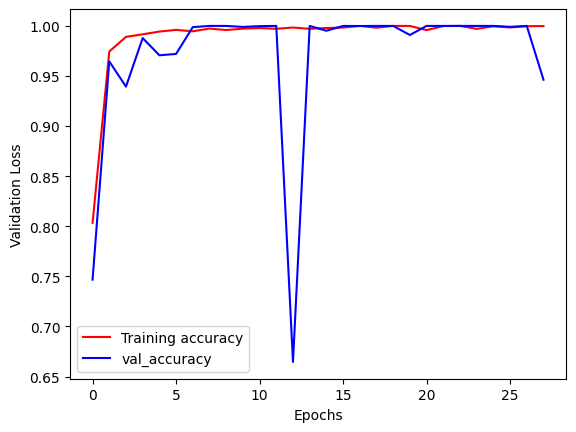

In [11]:
plt.plot(np.sqrt(hist.history['accuracy']), 'r', label='Training accuracy')
plt.plot(np.sqrt(hist.history['val_accuracy']), 'b', label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

In [12]:
print(hist.history['accuracy'])
best_score = max(hist.history['accuracy'])
# best_score2 = min(hist.history['val_loss'])
print(best_score)




[0.6455397605895996, 0.9495061039924622, 0.9782379865646362, 0.983352541923523, 0.9887679815292358, 0.9920774102210999, 0.9892694354057312, 0.9947350025177002, 0.9918267130851746, 0.9945845603942871, 0.9957879781723022, 0.9942837357521057, 0.9967406988143921, 0.9942335486412048, 0.9958381652832031, 0.996690571308136, 1.0, 0.9963896870613098, 1.0, 0.9999498724937439, 0.9916261434555054, 0.9996991157531738, 1.0, 0.9941834211349487, 0.9992478489875793, 0.9968911409378052, 0.9994985461235046, 0.9996991157531738]
1.0


In [13]:
print(y_test.shape)

(6233, 3)


In [14]:
model.save('model_file.h5')

c:\Users\simon\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
import keras_tuner
from tensorflow import keras

In [16]:
def build_model(hp):
    model2 = Sequential()
    model2.add(Dense(
        hp.Choice('units', [100, 150, 200, 250]),
        activation = 'relu'))
    model2.add(BatchNormalization())
    model2.add(Dense(
        hp.Choice('units', [100, 150, 200, 250]),
        activation = 'relu'))
    model2.add(BatchNormalization())
    model2.add(Dense(
        hp.Choice('units', [100, 150, 200, 250]),
        activation = 'relu'))
    model2.add(BatchNormalization())
    model2.add(Dense(3, activation = 'sigmoid'))
    model2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model2

In [17]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials = 100)

In [18]:
tuner.search(X_train, y_train, validation_split = 0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 4 Complete [00h 00m 03s]
val_loss: 1.1738427877426147

Best val_loss So Far: 0.557578444480896
Total elapsed time: 00h 00m 11s
INFO:tensorflow:Oracle triggered exit


In [19]:
predictions = best_model.predict(X_test)
import numpy as np
predicted_classes = np.argmax(predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)


195/195 [==============================] - 0s 851us/step


In [20]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_classes, predicted_classes)
print(f"Accuracy on test data: {accuracy:.2f}")


Accuracy on test data: 0.74


In [21]:
import os

# Define the file path
file_path = "./untitled_project/tuner0.json"  # Adjust the path if necessary

# Check if the file exists before attempting to delete it
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' deleted successfully.")
else:
    print(f"The file '{file_path}' does not exist.")


File './untitled_project/tuner0.json' deleted successfully.
